# Set up

Install packages :

In [1]:
# %pip install hdbscan

Python librairies imports :

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

import hdbscan

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import seaborn as sns
import mpl_extra.treemap as tr

%matplotlib inline
sns.set_theme(palette="tab10")

Load pycodestyle (PEP8) :

In [3]:
%load_ext pycodestyle_magic

In [4]:
%pycodestyle_on --max_line_length 125

Mount Google Drive :

In [5]:
work_loc = 'local'  # colab or local

project_path = "My Drive/OPENCLASSROOMS/Projets DATA/5. Segmentation ecommerce"

if (work_loc == 'colab'):
    # Mount Drive folder
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Drive path
    work_path = "/content/drive/"

elif (work_loc == 'local'):
    # Local drive path
    work_path = "/Users/victor/Library/CloudStorage/GoogleDrive-vicozer@gmail.com/"

else:
    raise ValueError("Choose between 'colab' or 'local' work!")

Load data :

In [6]:
# Load customers data
cust_df = pd.read_csv(work_path + project_path + "/project5_customer_cleaned.csv")

# Functions

## Plots functions

In [7]:
# Display countplot
def display_countplot(data, x=None, y=None, title='Countplot', figsize=(12, 8), order=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.countplot(data=data, x=x, y=y, order=order)
    plt.show()


# Display histplot
def display_histplot(data, x=None, y=None, title='Histplot', figsize=(12, 8), kde=False):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.histplot(data=data, x=x, y=y, kde=kde)
    plt.show()


# Display scatterplot
def display_scatterplot(data, x=None, y=None, title='Scatterplot', figsize=(8, 8), hue=None, palette=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=palette)
    if(hue is not None):
        plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
    plt.show()

In [8]:
# Display multi barplot
def display_multi_barplot(data, x, columns=None, title='Barplots', figsize=(25,20)):
    # Define columns
    if columns is None:
        columns=data.columns.to_list()
    columns_n = len(columns)

    # Compute size of plot
    if(columns_n < 4):
        fig_x = columns_n
        fig_y = 1
    elif(columns_n == 4):
        fig_x = 2
        fig_y = 2
    elif(columns_n < 6):
        fig_x = 4
        fig_y = 2
    else:
        fig_x = columns_n//3
        fig_y = 3
        if(columns_n%3 > 0): fig_x = fig_x + 1
    
    # Init fig
    fig, ax = plt.subplots(fig_x, fig_y, figsize=figsize)
    i, j = 0, 0

    # Title 
    plt.suptitle(title, fontsize=15)

    # Loop on columns
    for col in columns:
        if(fig_y==1):
            ax_ = ax[i]
        else:
            ax_ = ax[i,j]
        sns.barplot(y=col, x=x, data=data, ax=ax_)
        # Manage grid
        j += 1
        if(j > (fig_y - 1)): 
            j = 0
            i += 1

    # plt.tight_layout()
    plt.show()

2:79: E231 missing whitespace after ','
5:16: E225 missing whitespace around operator
21:21: E228 missing whitespace around modulo operator
21:28: E701 multiple statements on one line (colon)
22:1: W293 blank line contains whitespace
27:12: W291 trailing whitespace
32:17: E225 missing whitespace around operator
35:23: E231 missing whitespace after ','
39:29: W291 trailing whitespace


## Apply functions

In [9]:
# Apply function rfm segments from dictionary
def apply_rfm_segment(rfm_score, **dictionary):
    segment = 'NOT_FOUND'

    for rfm_seg, rfm_score_list in dictionary.items():
        if rfm_score in rfm_score_list:
            segment = rfm_seg
            break

    return segment

# Segmentation RFM

I use the order grouped dataframe to create a new dataframe for RFM segmentation.

In [10]:
# Create dataframe
rfm_df = cust_df[['orders_days_since_last', 'orders_number', 'payments_value_sum']].copy()
rfm_df = rfm_df.rename(columns={'orders_days_since_last': "recency",
                                'orders_number': "frequency",
                                'payments_value_sum': "monetary"})

display(rfm_df.head(10))

recency  frequency  monetary
0      111          1  2.151982
1      114          1  1.434409
2      536          1  1.935608
3      320          1  1.639686
4      287          1  2.294224
5      145          1  2.222664
6      131          1  1.548758
7      182          1  2.622401
8      542          1  2.176439
9      169          1  2.113141

Let's display the RFM distributions.

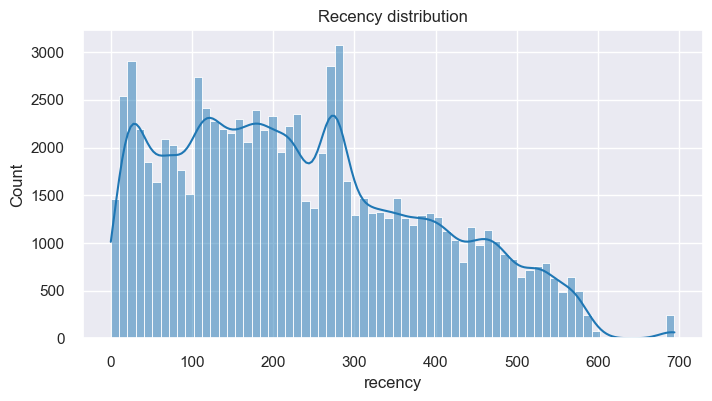

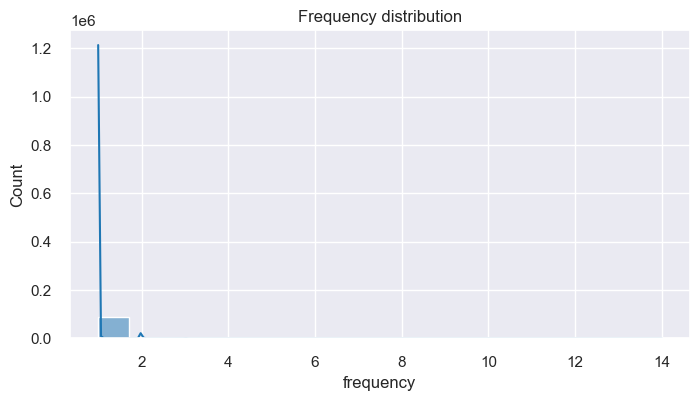

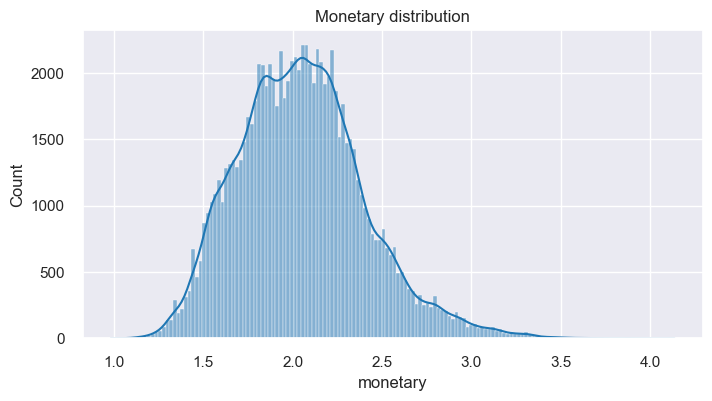

In [11]:
for col in rfm_df.columns:
    display_histplot(data=rfm_df, x=col, figsize=(8, 4),
                     title=col.capitalize()+" distribution", kde=True)
    print("\n")

I calculate the RFM scores using the quartiles.

In [12]:
rfm_df['R_score'] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['F_score'] = pd.cut(rfm_df['frequency'], [0., 1., 2., 4., 6., 15.], labels=[1, 2, 3, 4, 5])
rfm_df['M_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm_df['RFM_score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

display(rfm_df.head(10))

recency  frequency  monetary R_score F_score M_score RFM_score
0      111          1  2.151982       4       1       4       414
1      114          1  1.434409       4       1       1       411
2      536          1  1.935608       1       1       2       112
3      320          1  1.639686       2       1       1       211
4      287          1  2.294224       2       1       4       214
5      145          1  2.222664       4       1       4       414
6      131          1  1.548758       4       1       1       411
7      182          1  2.622401       3       1       5       315
8      542          1  2.176439       1       1       4       114
9      169          1  2.113141       4       1       3       413

Then I segment the customers based on the R and F scores. 

Here is the description of the segments:
* **Champions** :	Bought recently, buy often and spend the most
* **Loyal customers** :	Buy on a regular basis. Responsive to promotions.
* **Potential loyalist** :	Recent customers with average frequency.
* **New customers** : Bought most recently, but not often.
* **Promising** : Recent shoppers, but haven’t spent much.
* **Customers needing attention** : Above average recency, frequency and monetary values. May not have bought very recently though.
* **About to sleep** : Below average recency and frequency. Will lose them if not reactivated.
* **At risk** : Purchased often but a long time ago. Need to bring them back!
* **Can’t lose them** : Used to purchase frequently but haven’t returned for a long time.
* **Hibernating** : Last purchase was long back and low number of orders. May be lost.

In [13]:
rfm_dict = {
    'champions': [555, 554, 544, 545, 454, 455, 445],
    'loyal customers': [543, 444, 435, 355, 354, 345, 344, 335],
    'potential loyalists': [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441,
                            431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323],
    'new customers': [512, 511, 422, 421, 412, 411, 311],
    'promising': [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313],
    'need attention': [535, 534, 443, 434, 343, 334, 325, 324],
    'cannot lose them': [155, 154, 144, 214, 215, 115, 114, 113],
    'about to sleep': [331, 321, 312, 221, 213, 332, 322],
    'at risk': [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143,
                142, 135, 134, 133, 125, 124],
    'hibernating': [231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211, 111, 112, 121, 131, 141, 151]
}

I apply RFM segment dictionary.

In [14]:
# Apply rfm dictionary
rfm_df['RFM_segment'] = rfm_df['RFM_score'].astype(int).apply(apply_rfm_segment, **rfm_dict)

display(rfm_df.head(10))

recency  frequency  monetary R_score F_score M_score RFM_score  \
0      111          1  2.151982       4       1       4       414   
1      114          1  1.434409       4       1       1       411   
2      536          1  1.935608       1       1       2       112   
3      320          1  1.639686       2       1       1       211   
4      287          1  2.294224       2       1       4       214   
5      145          1  2.222664       4       1       4       414   
6      131          1  1.548758       4       1       1       411   
7      182          1  2.622401       3       1       5       315   
8      542          1  2.176439       1       1       4       114   
9      169          1  2.113141       4       1       3       413   

        RFM_segment  
0         promising  
1     new customers  
2       hibernating  
3       hibernating  
4  cannot lose them  
5         promising  
6     new customers  
7         promising  
8  cannot lose them  
9         promising

Let's visualize the RFM segmentation.

promising              32626
new customers          17884
cannot lose them       16969
hibernating            15037
about to sleep          7071
at risk                  723
need attention           518
potential loyalists      146
loyal customers           69
champions                 10
Name: RFM_segment, dtype: int64

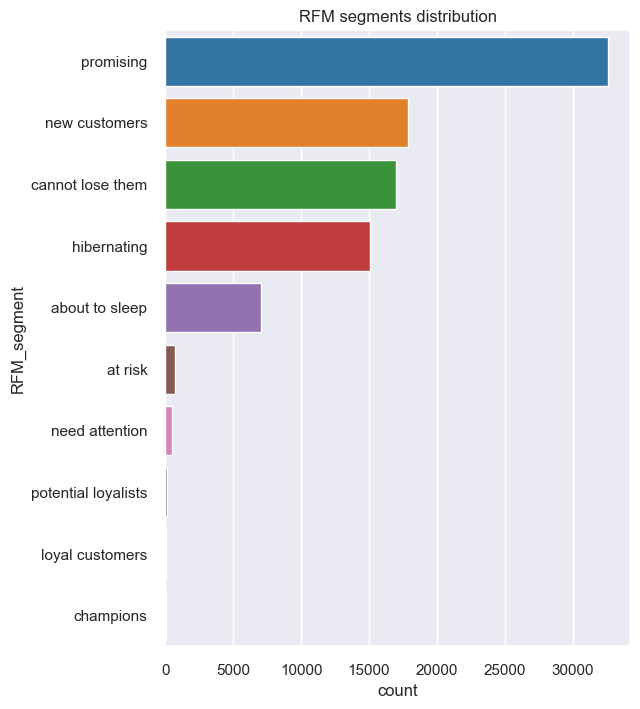

In [15]:
display(rfm_df['RFM_segment'].value_counts())
display_countplot(rfm_df, y='RFM_segment', title='RFM segments distribution', figsize=(6, 8),
                  order=rfm_df['RFM_segment'].value_counts().sort_values(ascending=False).index)

In [16]:
rfm_df.groupby('RFM_segment').mean(numeric_only=True).sort_values('monetary')

recency  frequency  monetary
RFM_segment                                         
new customers        115.992060   1.002069  1.682402
hibernating          394.923987   1.015030  1.724153
about to sleep       266.183001   1.004101  1.935019
potential loyalists  173.383562   2.047945  2.043112
promising            130.076534   1.028627  2.265932
cannot lose them     409.123755   1.000000  2.317356
at risk              380.175657   2.094053  2.455904
need attention       197.895753   2.146718  2.461828
loyal customers      165.463768   3.405797  2.691608
champions             83.100000   6.400000  2.887475

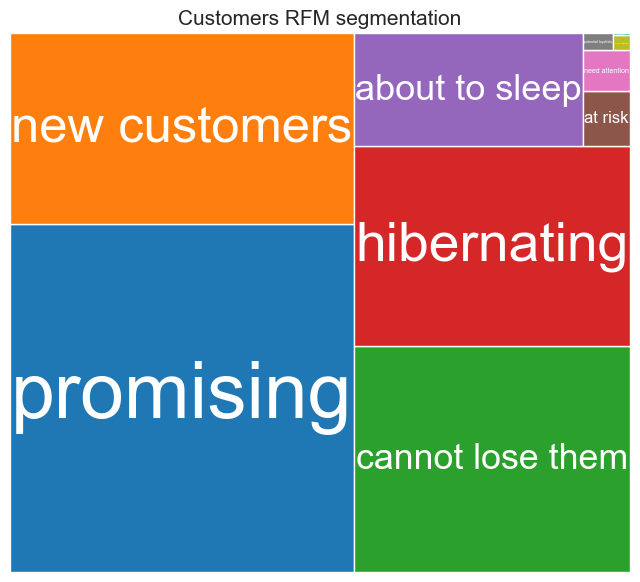

In [17]:
tr_df = pd.DataFrame({'values': rfm_df["RFM_segment"].value_counts().values,
                      'labels': rfm_df["RFM_segment"].value_counts().index})

fig, ax = plt.subplots(figsize=(8, 7))
tr.treemap(ax, tr_df, area='values', labels='labels', fill='labels', cmap='tab10',
           rectprops=dict(ec='w'), textprops=dict(c='w'))
ax.axis('off')
plt.title('Customers RFM segmentation', fontsize=15)
plt.show()

# Prepare data

First I add the RFM segments to the customer database.

In [18]:
cust_df['RFM_segment'] = rfm_df['RFM_segment']

I then standarize the data.

In [19]:
# Create features matrix
x = cust_df.drop(columns='RFM_segment').values
y = cust_df['RFM_segment'].values

# Standardize features
x_std = StandardScaler().fit_transform(x)

I also create sampled data to avoid kernel crashes.

In [20]:
# Sample the dataframe
cust_smpl = cust_df.sample(10000, random_state=0)

# Create features matrix
x_smpl = cust_smpl.drop(columns='RFM_segment').values
y_smpl = cust_smpl['RFM_segment'].values

# Standardize features
x_smpl_std = StandardScaler().fit_transform(x_smpl)

# Dimensions reduction

## Principal component analysis (PCA)

I use the PCA projection on 2 components.

In [21]:
# PCA projection to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_std)
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])

# Add RFM segments
pca_df['RFM_segment'] = y

display(pca_df.head(5))
print("The three components explain {0:.1%} of the variance".format(pca.explained_variance_ratio_.sum()))

PC1       PC2       RFM_segment
0  0.340488  1.004996         promising
1 -3.446965  0.659925     new customers
2 -0.206487  0.039173       hibernating
3 -0.687711 -3.018708       hibernating
4  0.878954  0.347141  cannot lose them

The three components explain 18.0% of the variance


Let's display the 2D projection.

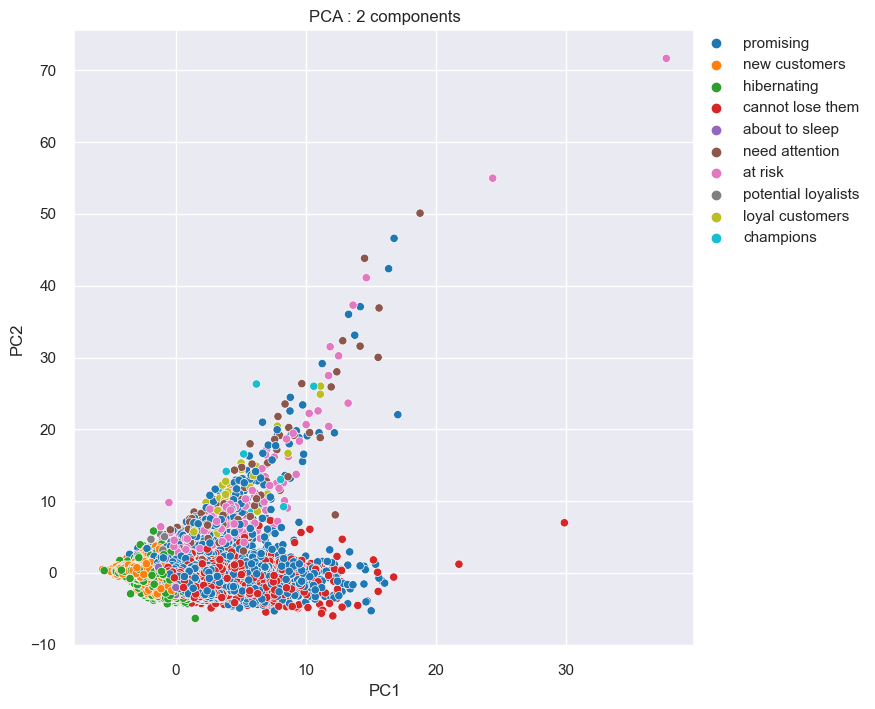

In [22]:
# Display projection
display_scatterplot(data=pca_df, x='PC1', y='PC2', title='PCA : 2 components', hue='RFM_segment')

## t-Distributed stochastic neighbor embedding (t-SNE)

I use the t-SNE projection on 2 components with different perplexity values.

TSNE with perplexity= 5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


tSNE1       tSNE2       RFM_segment
0  14.027348   60.094116         promising
1 -39.191509  -23.984936     new customers
2  18.093033  -94.708176       hibernating
3 -59.181332 -102.359619       hibernating
4 -57.132984  -33.920326  cannot lose them

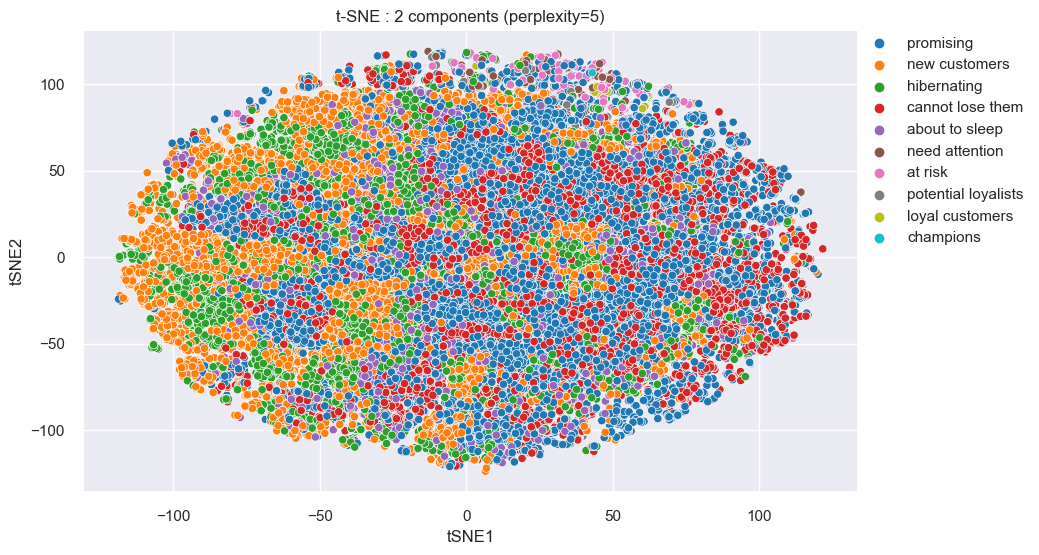

TSNE with perplexity= 30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


tSNE1      tSNE2       RFM_segment
0  19.661528  58.424313         promising
1 -36.112583 -63.907501     new customers
2  12.379344 -99.763855       hibernating
3 -39.218235 -11.781593       hibernating
4 -60.065262  -1.724092  cannot lose them

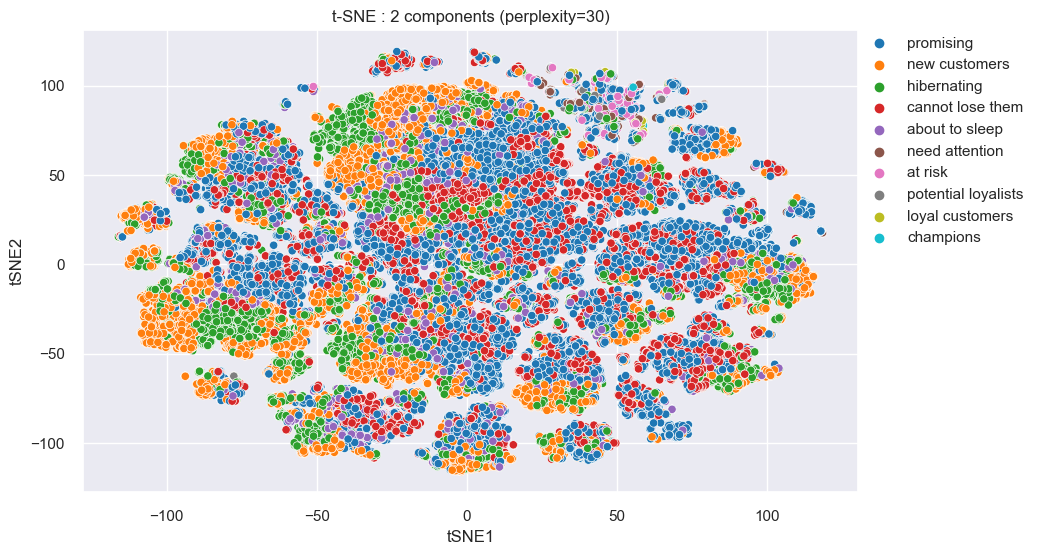

TSNE with perplexity= 50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


tSNE1       tSNE2       RFM_segment
0  15.283618   47.017128         promising
1 -10.608299  -81.713577     new customers
2  12.525179 -104.023460       hibernating
3 -30.910446  -24.262939       hibernating
4 -64.270149   -1.235057  cannot lose them

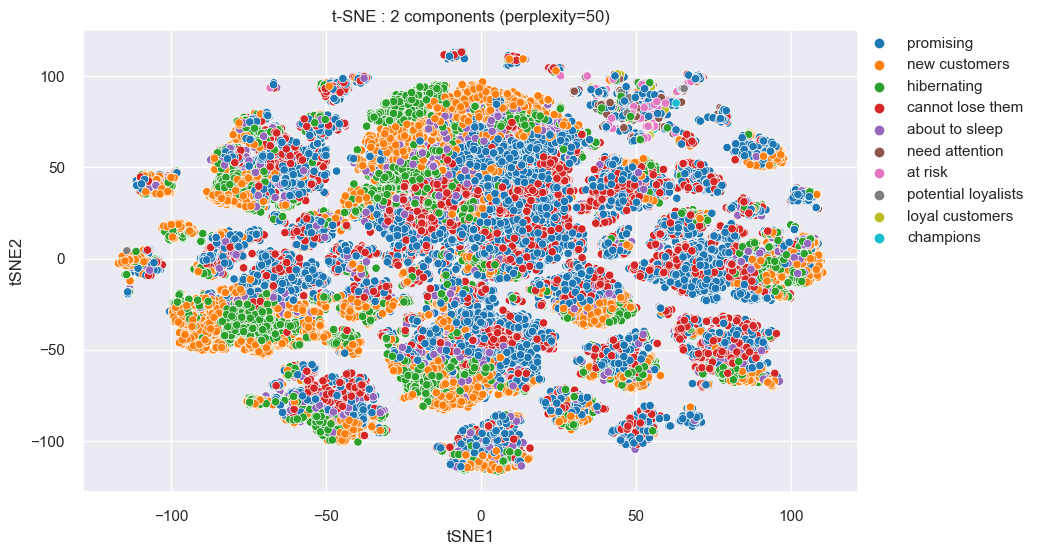

In [23]:
# Perplexity values
perplixities = [5, 30, 50]

# t-SNE on 2 components
for perplexity in perplixities:
    print("TSNE with perplexity=", perplexity)
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', learning_rate='auto')
    tsne_data = tsne.fit_transform(x_std)
    tsne_df = pd.DataFrame(data=tsne_data, columns=['tSNE1', 'tSNE2'])

    # Add RFM segments
    tsne_df['RFM_segment'] = y

    display(tsne_df.head(5))

    # Display projection
    display_scatterplot(data=tsne_df, x='tSNE1', y='tSNE2',
                        title="t-SNE : 2 components (perplexity="+str(perplexity)+")",
                        figsize=(10, 6),
                        hue='RFM_segment')

## Isomap

I use the Isomap projection on 2 components.
<br>(I use the sampled data to avoid kernel crashes.)

In [24]:
# Projection to 2 components
iso = Isomap(n_neighbors=16, n_components=2)
iso_data = iso.fit_transform(x_smpl_std)
iso_df = pd.DataFrame(data=iso_data, columns=['ISO1', 'ISO2'])

# Add RFM segments
iso_df['RFM_segment'] = y_smpl

display(iso_df.head(5))

ISO1      ISO2     RFM_segment
0 -0.451446 -0.831499     hibernating
1  1.464378  0.862834   new customers
2  5.949682 -0.685454       promising
3 -0.244934 -0.220185  about to sleep
4  1.954578 -1.927788       promising

Let's display the 2D projection.

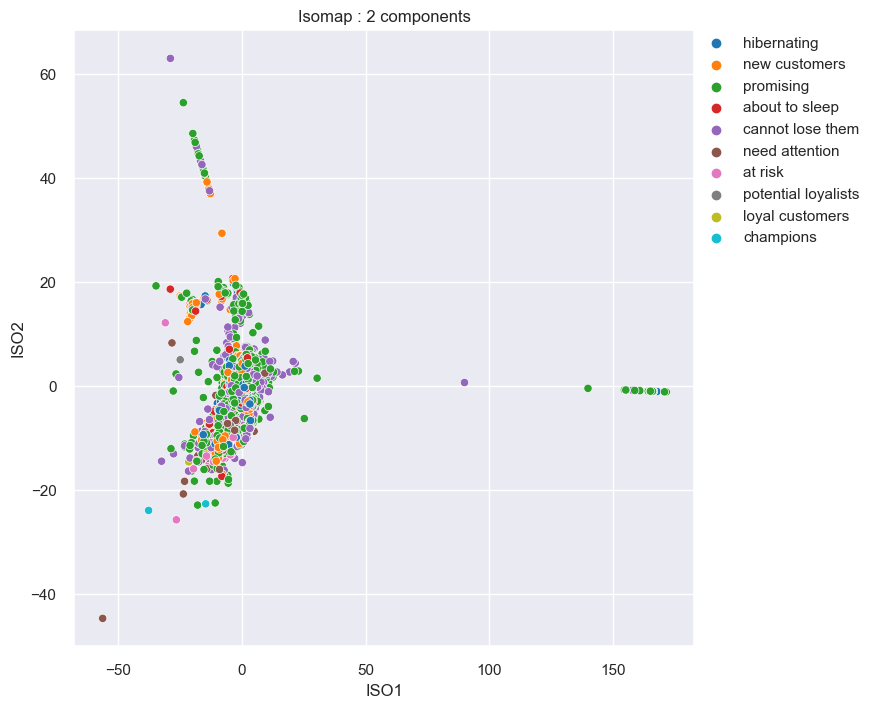

In [25]:
# Display projection
display_scatterplot(data=iso_df, x='ISO1', y='ISO2', title='Isomap : 2 components', hue='RFM_segment')

# Clustering algorithms

Create array to store all clustering results.

In [26]:
# Create empty array to store results
res_silhouettes = []
res_dbscores = []
res_clusters = []
res_algo = []

# Store model and labels found for each algorithm
res_agglo_labels = []
res_agglo_model = []
res_hdb_labels = []
res_hdb_models = []
res_km_labels = []
res_km_models = []

## Hierarchical clustering

I first use the *AgglomerativeClustering* algorithm with different numbers of clusters.

Here I have to use the sampled data to avoid kernel crashes.

In [27]:
range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:

    # Fit agglomerative model
    agglo = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    agglo_labels = agglo.fit_predict(x_smpl_std)

    # Compute metrics
    agglo_silhouette = silhouette_score(x_smpl_std, agglo_labels)
    agglo_dbscore = davies_bouldin_score(x_smpl_std, agglo_labels)

    # Store results
    res_algo.append("AGGLOMERATIVE")
    res_clusters.append(n_clusters)
    res_silhouettes.append(agglo_silhouette)
    res_dbscores.append(agglo_dbscore)
    res_agglo_labels.append(agglo_labels)
    res_agglo_model.append(agglo)

    print("For n_clusters =", n_clusters, ", the silhouette_score is :", agglo_silhouette)

For n_clusters = 4 , the silhouette_score is : 0.15125523230063798
For n_clusters = 5 , the silhouette_score is : 0.1600665265242219
For n_clusters = 6 , the silhouette_score is : 0.08938496716913032
For n_clusters = 7 , the silhouette_score is : 0.0994787341904498
For n_clusters = 8 , the silhouette_score is : 0.11385289226342156


I generate the linkage matrix and visualize the hierarchical clustering dendogram.

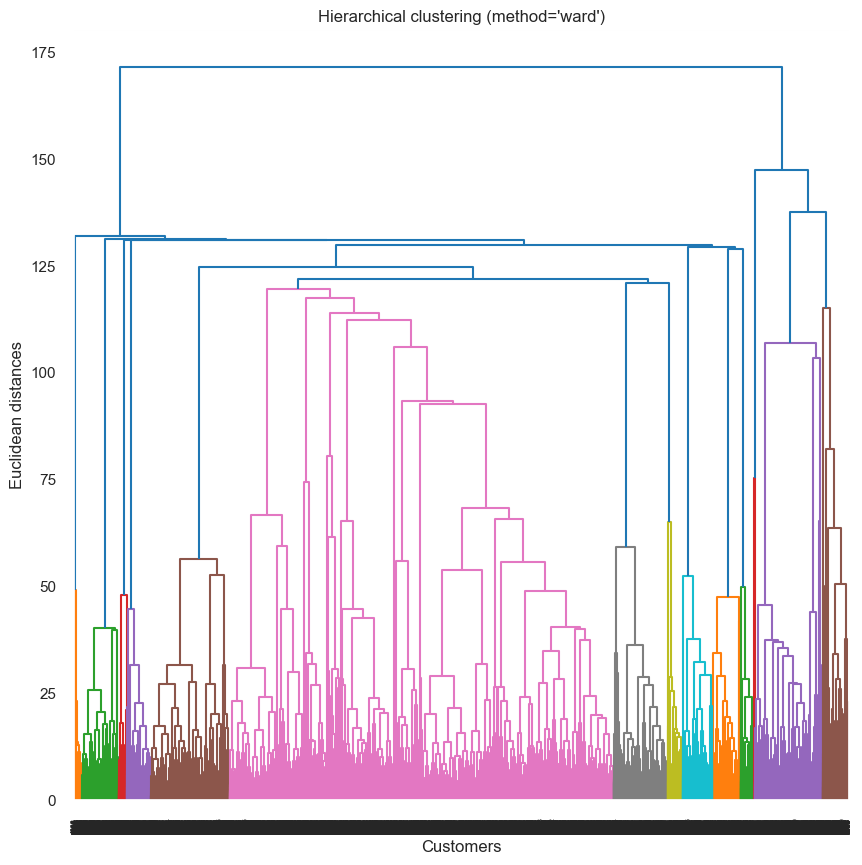

In [28]:
# Generate the linkage matrix
Z = linkage(x_smpl_std, method='ward')

# Display dendrogram
plt.figure(figsize=(10, 10))
dendrogram(Z)
plt.title("Hierarchical clustering (method='ward')")
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

## Hierarchical density-based spatial clustering of applications with noise (HDBSCAN)

I use the *HDBSCAN* clustering algorithm.

In [29]:
# Define min cluster sizes to test
min_cluster_sizes = [10, 20, 100, 200]

for min_cluster_size in min_cluster_sizes:

    # Fit hdbscan
    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, memory="/Users/victor/Documents/OPENCLASSROOMS")
    hdb_labels = hdb.fit_predict(x_std)

    # Number of clusters in labels, ignoring noise if present
    n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    # n_noise = list(hdb_labels).count(-1)

    # Compute metrics
    hdb_silhouette = silhouette_score(x_std, hdb_labels)
    hdb_dbscore = davies_bouldin_score(x_std, hdb_labels)

    # Store results
    res_algo.append('HDBSCAN')
    res_clusters.append(n_clusters)
    res_silhouettes.append(hdb_silhouette)
    res_dbscores.append(hdb_dbscore)
    res_hdb_labels.append(hdb_labels)
    res_hdb_models.append(hdb)

    print("For n_clusters =", n_clusters, ", the silhouette_score is :", hdb_silhouette)

For n_clusters = 56 , the silhouette_score is : 0.11483392537583136
For n_clusters = 39 , the silhouette_score is : 0.10326558799922252
For n_clusters = 24 , the silhouette_score is : 0.045406926831097344
For n_clusters = 18 , the silhouette_score is : 0.018583185255651346


I display the different HDBSCAN models.

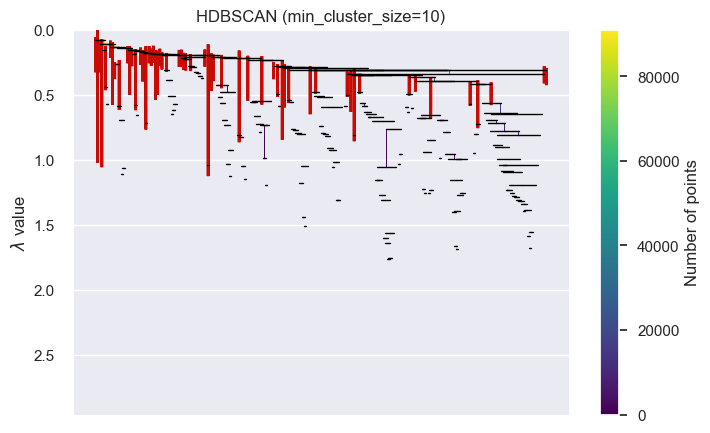

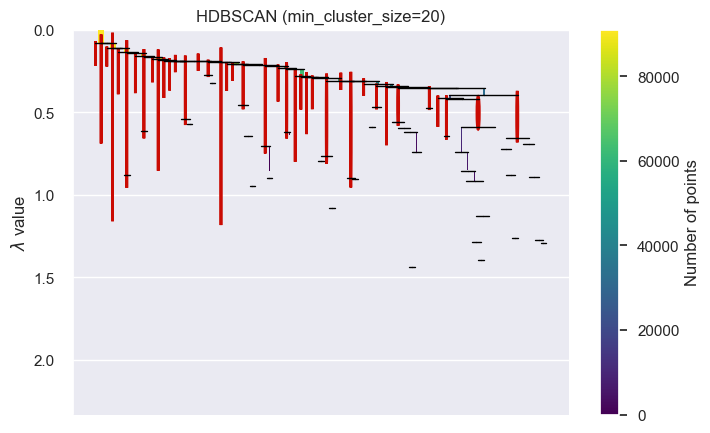

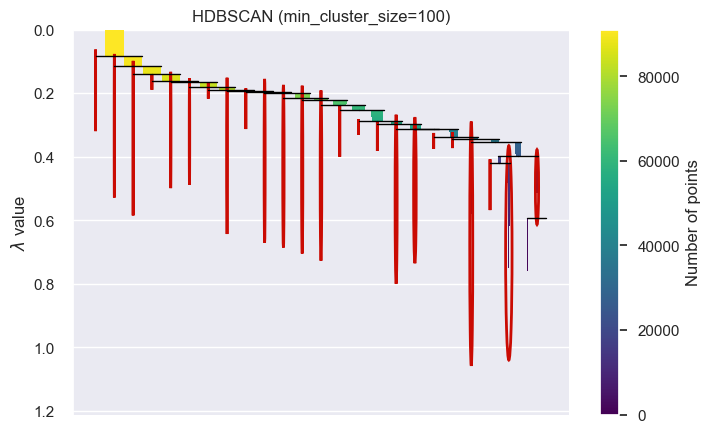

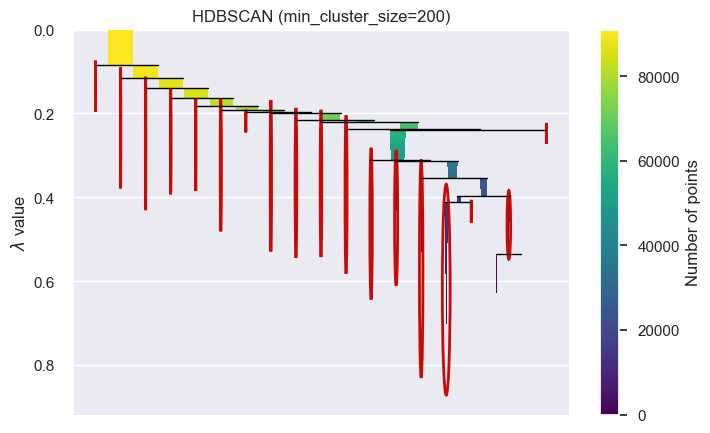

In [30]:
# Display hdb models
for hdb in res_hdb_models:
    plt.figure(figsize=(8, 5))
    plt.title("HDBSCAN (min_cluster_size="+str(hdb.min_cluster_size)+")")
    hdb.condensed_tree_.plot(select_clusters=True)
    plt.show()

## K-Means clustering

I use the *K-Means* algorithm.

First I want to find the optimal number of clusters with the elbow method (with *Yellowbrick* library).

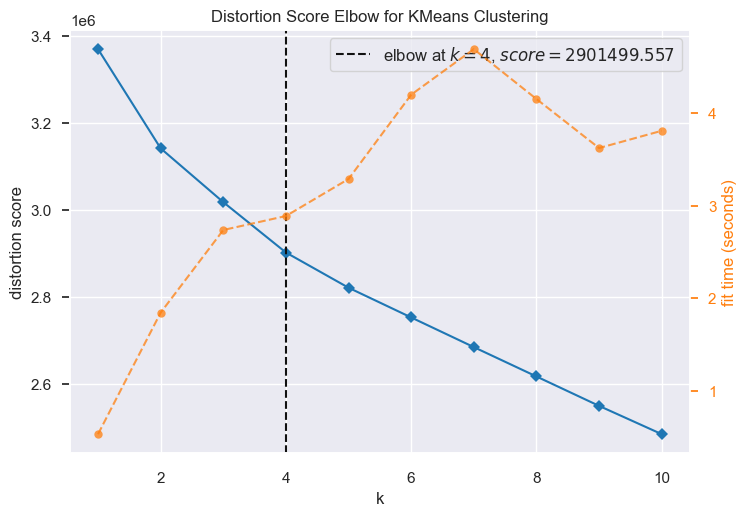

In [31]:
# Instantiate the clustering model and visualizer
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1, 11))

visualizer.fit(x_std)    # Fit the data to the visualizer
visualizer.finalize()
plt.show()

The optimal number of clusters seems to be 4.

Still I try the KMeans clustering algorithm with different number of clusters.

In [32]:
# Cluster ranges
range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:

    # Fit and predict KMeans model
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(x_std)

    # Compute metrics
    km_silhouette = silhouette_score(x_std, km_labels)
    km_dbscore = davies_bouldin_score(x_std, km_labels)

    # Store results
    res_algo.append('KMEANS')
    res_clusters.append(n_clusters)
    res_silhouettes.append(km_silhouette)
    res_dbscores.append(km_dbscore)
    res_km_models.append(km)
    res_km_labels.append(km_labels)

    print("For n_clusters =", n_clusters, ", the silhouette_score is :", km_silhouette)

For n_clusters = 4 , the silhouette_score is : 0.10461915733120024
For n_clusters = 5 , the silhouette_score is : 0.06200876450248116
For n_clusters = 6 , the silhouette_score is : 0.11921171599650714
For n_clusters = 7 , the silhouette_score is : 0.12062058274409636
For n_clusters = 8 , the silhouette_score is : 0.06819129204117057


I use the *YellowBricks* library to visualize the silhouettes from the computed *K-Means* models.

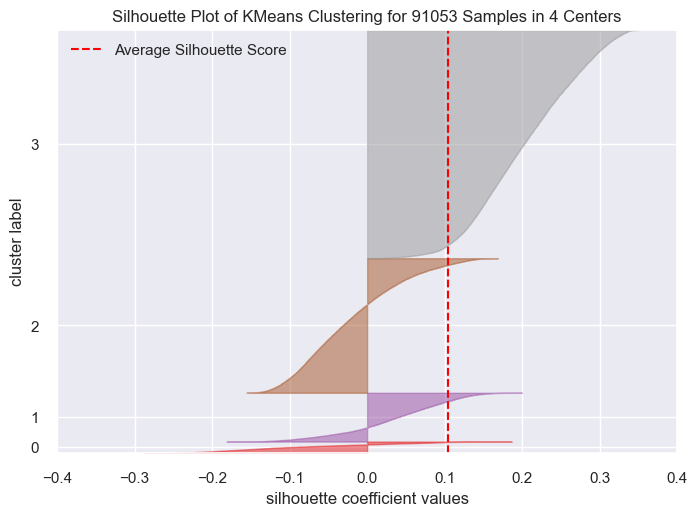

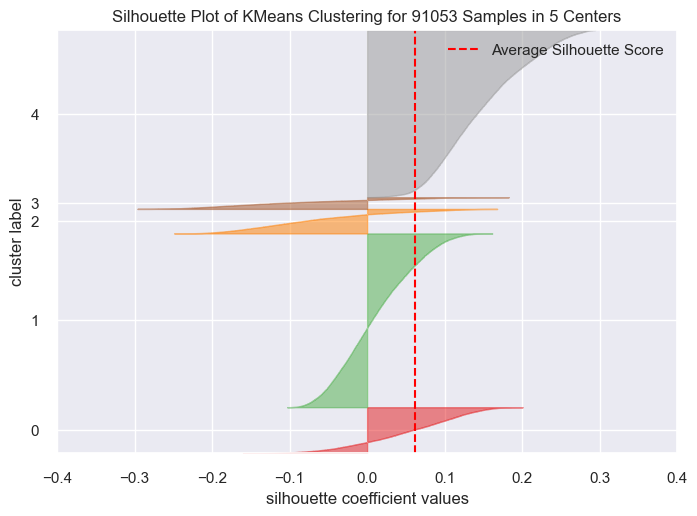

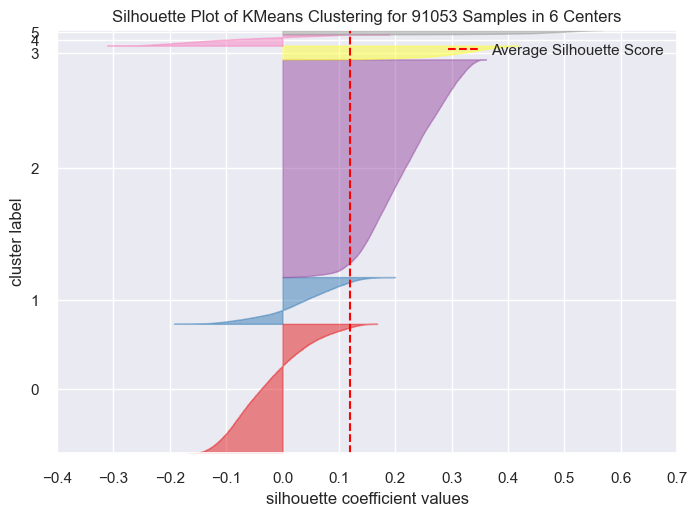

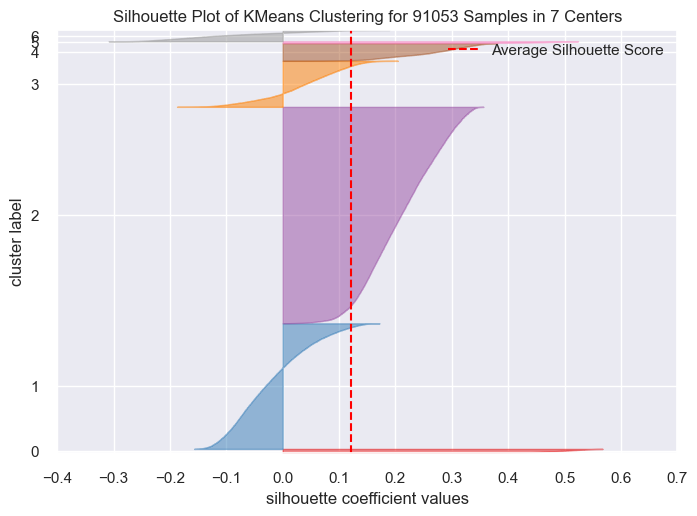

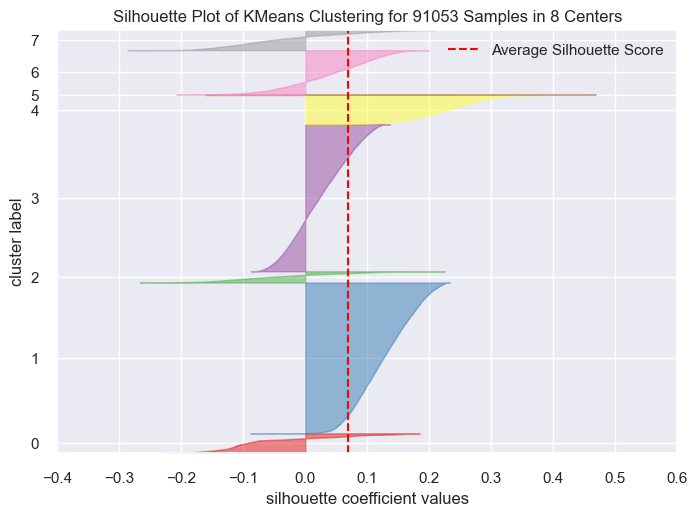

In [33]:
# Shows the clusters silhouette
for km in res_km_models:
    visualizer = SilhouetteVisualizer(km)

    visualizer.fit(x_std)  # Fit the data to the visualizer
    visualizer.finalize()
    plt.show()

# Visualization of clusters

## Results

I create a dataframe with metrics results from the clustering models.

In [34]:
# Create results dataframe
res_df = pd.DataFrame(data={'model': res_algo, 'n_clusters': res_clusters,
                            'silhouette_score': res_silhouettes, 'db_score': res_dbscores})

display(res_df)

model  n_clusters  silhouette_score  db_score
0   AGGLOMERATIVE           4          0.151255  1.989507
1   AGGLOMERATIVE           5          0.160067  1.781436
2   AGGLOMERATIVE           6          0.089385  1.791720
3   AGGLOMERATIVE           7          0.099479  1.672822
4   AGGLOMERATIVE           8          0.113853  1.646956
5         HDBSCAN          56          0.114834  1.695674
6         HDBSCAN          39          0.103266  1.796076
7         HDBSCAN          24          0.045407  1.956849
8         HDBSCAN          18          0.018583  2.074274
9          KMEANS           4          0.104619  2.642345
10         KMEANS           5          0.062009  2.743679
11         KMEANS           6          0.119212  2.161501
12         KMEANS           7          0.120621  2.010750
13         KMEANS           8          0.068191  2.319307

I display the silhouettes scores by cluters number.

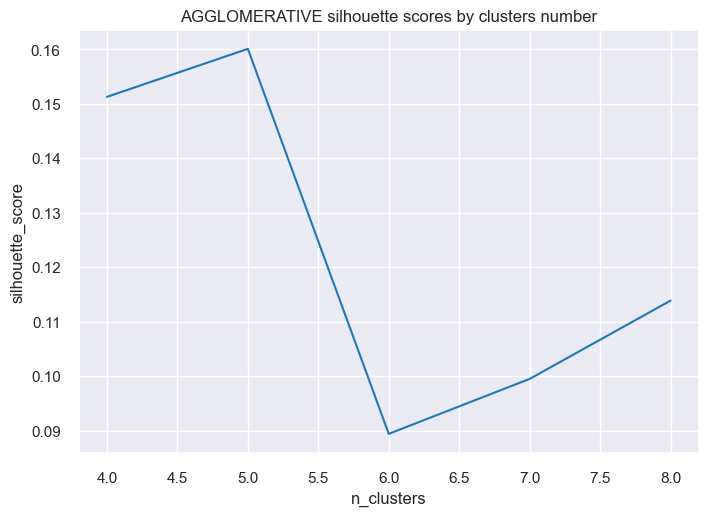

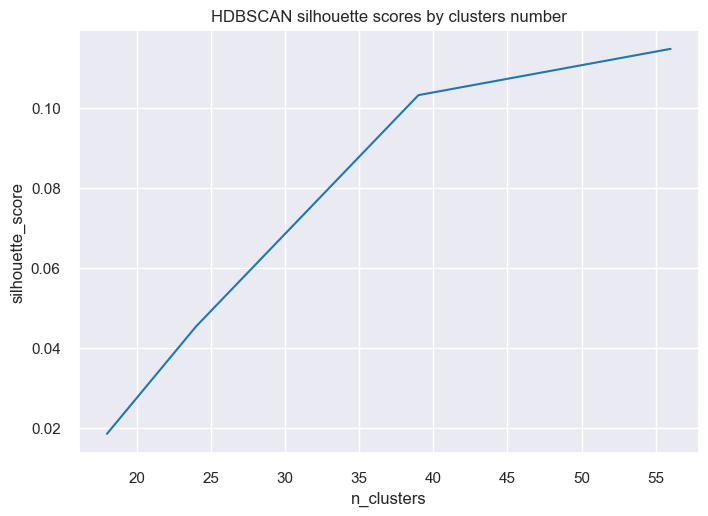

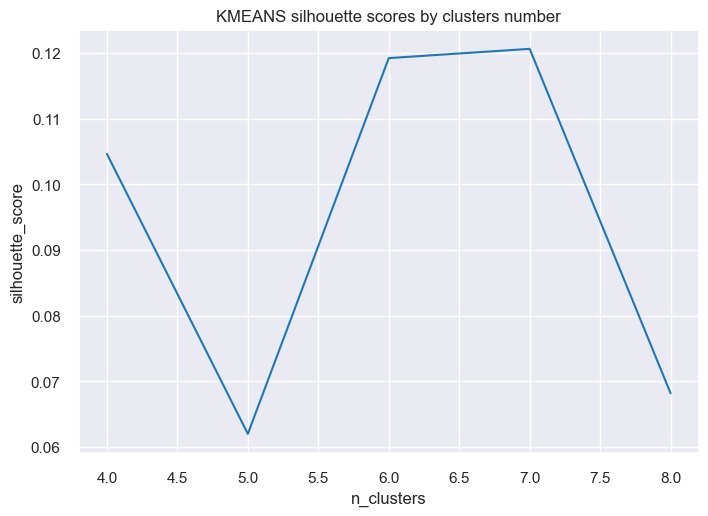

In [35]:
# Display silhouette scores
for model in res_df['model'].unique().tolist():
    model_data = res_df[res_df['model'] == model]
    sns.lineplot(data=model_data, y='silhouette_score', x='n_clusters')
    plt.title(model + " silhouette scores by clusters number")
    plt.show()

Then the davies-bouldin scores by clusters number.

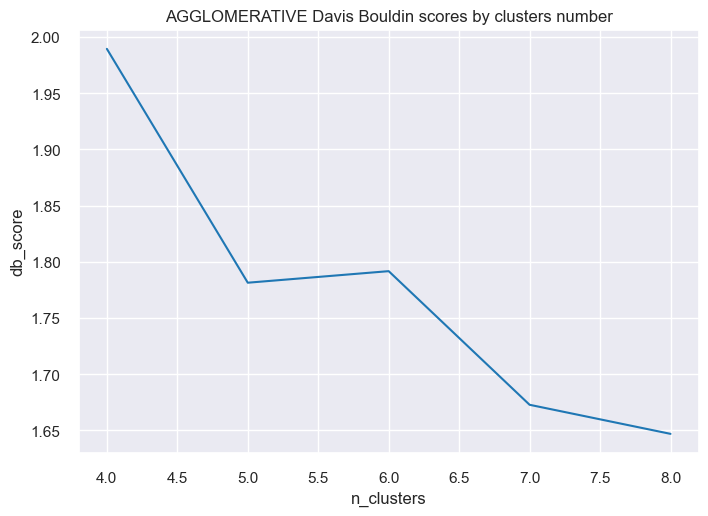

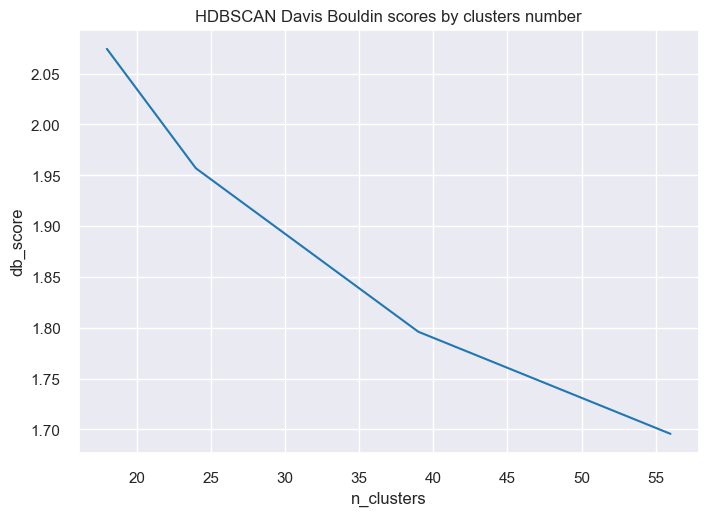

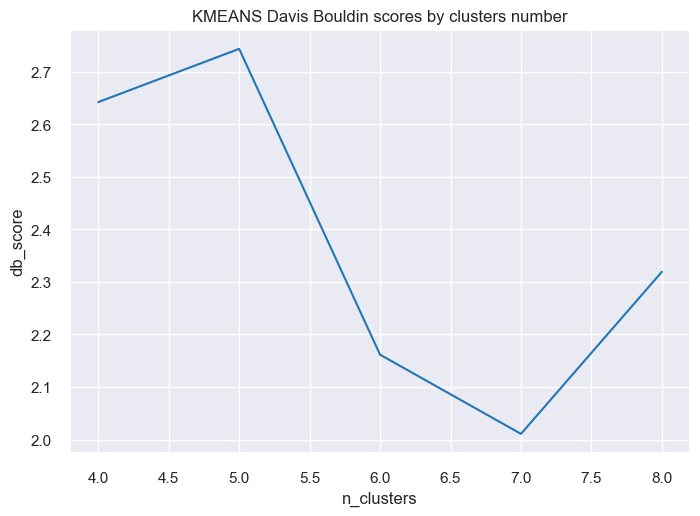

In [36]:
# Display davies bouldin scores
for model in res_df['model'].unique().tolist():
    model_data = res_df[res_df['model'] == model]
    sns.lineplot(data=model_data, y='db_score', x='n_clusters')
    plt.title(model + " Davis Bouldin scores by clusters number")
    plt.show()

Because the agglomerative clustering is only computed on a sample of the data, I choose to only focus on the *HDBSCAN* and *KMeans* models now.

In [37]:
# Compute best clustering based on silhouette score
km_idxmax = res_df[res_df['model'] == 'KMEANS'].reset_index()['silhouette_score'].idxmax()
km_df_idxmax = res_df[res_df['model'] == 'KMEANS']['silhouette_score'].idxmax()
hdb_idxmax = res_df[res_df['model'] == 'HDBSCAN'].reset_index()['silhouette_score'].idxmax()
hdb_df_idxmax = res_df[res_df['model'] == 'HDBSCAN']['silhouette_score'].idxmax()

print("The best KMEANS model (silhouette_score={}) contains {} clusters"
      .format(res_df.iloc[[km_df_idxmax]]['silhouette_score'].values[0],
              res_df.iloc[[km_df_idxmax]]['n_clusters'].values[0]))
print("The best HDBSCAN model (silhouette_score={}) contains {} clusters"
      .format(res_df.iloc[[hdb_df_idxmax]]['silhouette_score'].values[0],
              res_df.iloc[[hdb_df_idxmax]]['n_clusters'].values[0]))

The best KMEANS model (silhouette_score=0.12062058274409636) contains 7 clusters
The best HDBSCAN model (silhouette_score=0.11483392537583136) contains 56 clusters


The *KMeans* model with 4 clusters has the best silhouette score. 
<br> However it has the worst Davies Bouldin score and 4 clusters is a little low for a marketing analysis. 

I decide to use the *KMeans* model with 7 clusters (second best silhouette score and Davies Bouldin score) as the best *KMeans* model.

In [38]:
# Select the KMeans model with 7 clusters as best model
km_idxmax = res_df[res_df['model'] == 'KMEANS'].reset_index()[res_df['n_clusters'] == 7].index.values[0]

/var/folders/rg/wbhs03nj48xcm1vjyh32cych0000gn/T/ipykernel_57832/4239364631.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  km_idxmax = res_df[res_df['model'] == 'KMEANS'].reset_index()[res_df['n_clusters'] == 7].index.values[0]


## Principal component analysis (PCA)

I use the PCA projection on 2 components.

In [39]:
# Add HDBSCAN and KMEANS labels
pca_df['HDBSCAN_labels'] = res_hdb_labels[hdb_idxmax]
pca_df['KMEANS_labels'] = res_km_labels[km_idxmax]

display(pca_df.head(5))

PC1       PC2       RFM_segment  HDBSCAN_labels  KMEANS_labels
0  0.340488  1.004996         promising              55              1
1 -3.446965  0.659925     new customers              49              2
2 -0.206487  0.039173       hibernating              25              2
3 -0.687711 -3.018708       hibernating              52              3
4  0.878954  0.347141  cannot lose them              52              1

Let's display the 2D projection.

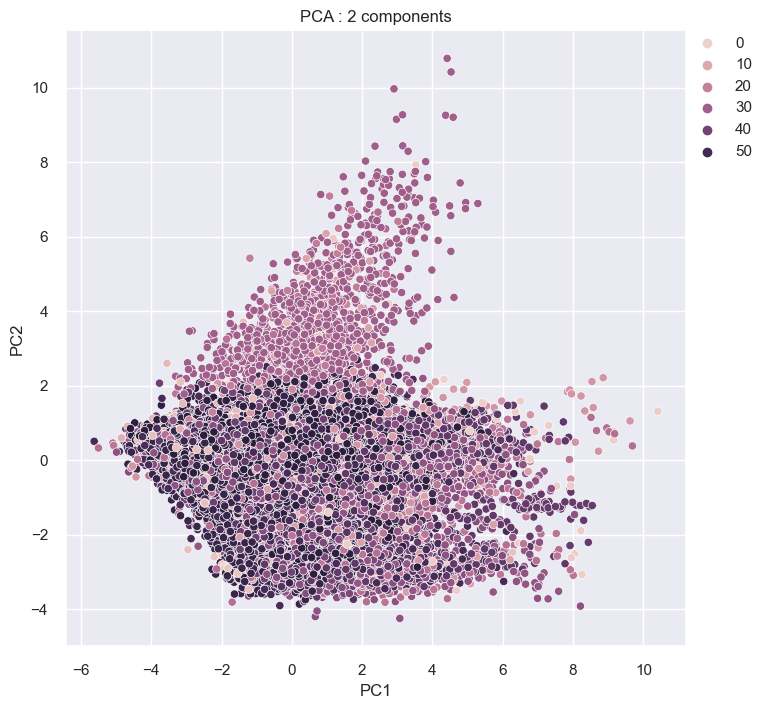

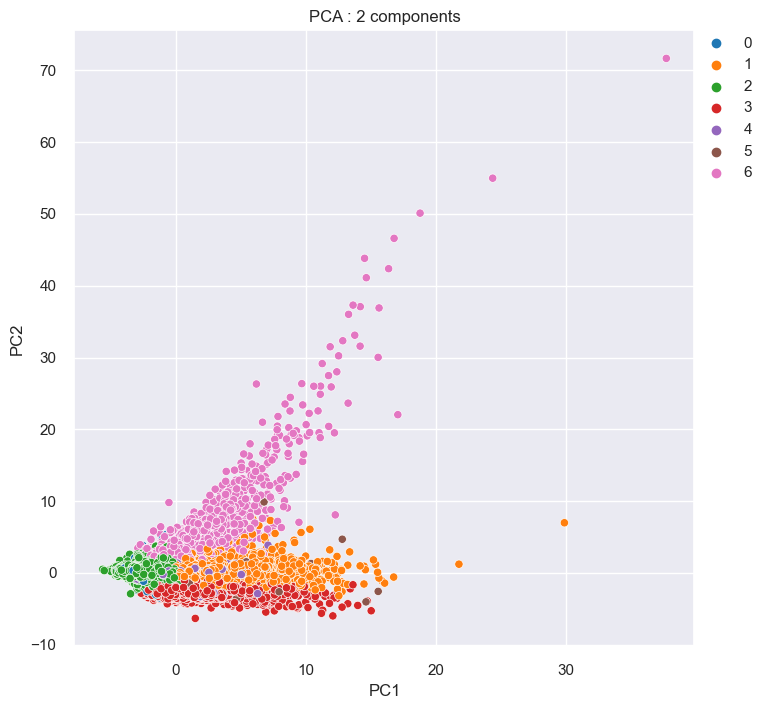

In [40]:
# Display projection
display_scatterplot(data=pca_df[pca_df['HDBSCAN_labels'] >= 0], x='PC1', y='PC2',
                    title='PCA : 2 components', hue='HDBSCAN_labels')
display_scatterplot(data=pca_df, x='PC1', y='PC2', title='PCA : 2 components', hue='KMEANS_labels', palette='tab10')

## t-Distributed stochastic neighbor embedding (t-SNE)

I use the t-SNE projection on 2 components.

In [41]:
# Add HDBSCAN and KMEANS labels
tsne_df['HDBSCAN_labels'] = res_hdb_labels[hdb_idxmax]
tsne_df['KMEANS_labels'] = res_km_labels[km_idxmax]

display(tsne_df.head(5))

tSNE1       tSNE2       RFM_segment  HDBSCAN_labels  KMEANS_labels
0  15.283618   47.017128         promising              55              1
1 -10.608299  -81.713577     new customers              49              2
2  12.525179 -104.023460       hibernating              25              2
3 -30.910446  -24.262939       hibernating              52              3
4 -64.270149   -1.235057  cannot lose them              52              1

Let's display the 2D projection.

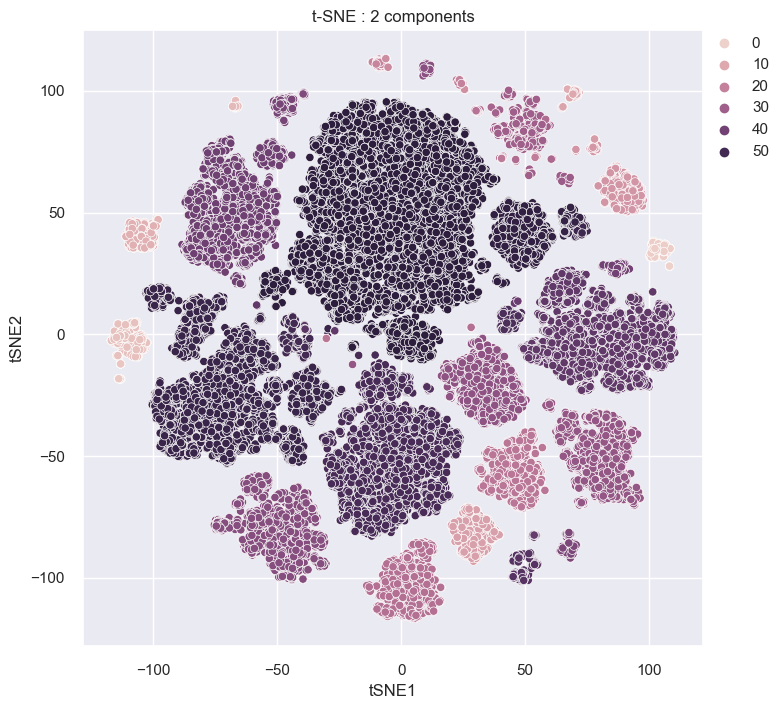

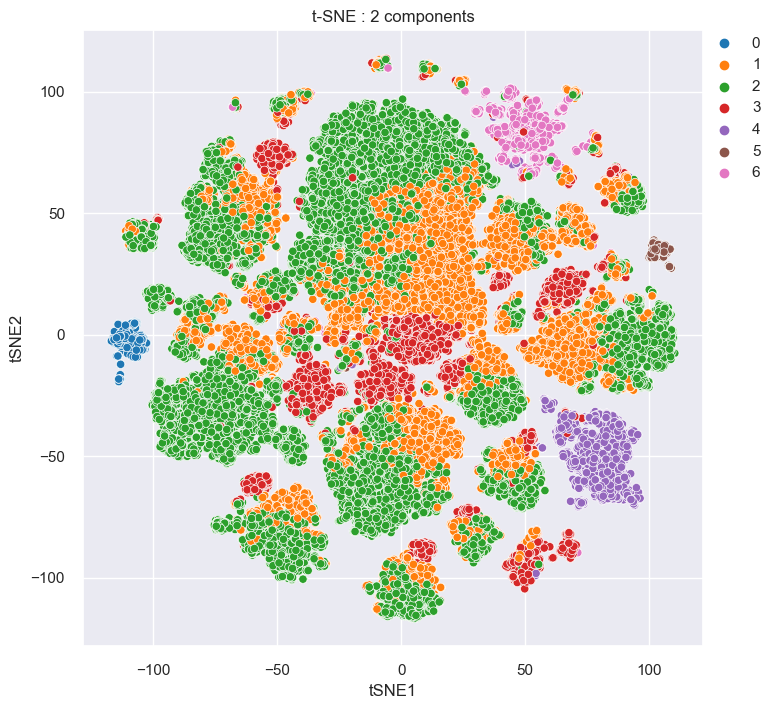

In [42]:
# Display projection
display_scatterplot(data=tsne_df[tsne_df['HDBSCAN_labels'] >= 0], x='tSNE1', y='tSNE2',
                    title='t-SNE : 2 components', hue='HDBSCAN_labels')
display_scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', title='t-SNE : 2 components', hue='KMEANS_labels', palette='tab10')

The best results with *HDBSCAN* gives 57 clusters which is too much to make a marketing analysis of the customers.

Thus we decide to select the *KMeans* model with **6 clusters** for the customer segmentation.

# Clusters analysis

In [43]:
# Get KMeans labels
cust_df['cluster'] = res_km_labels[km_idxmax]

display(cust_df.head(5))

orders_number  orders_days_since_last  orders_estimated_days_mean  \
0              1                     111                        10.0   
1              1                     114                         7.0   
2              1                     536                        27.0   
3              1                     320                        31.0   
4              1                     287                        20.0   

   payments_istlm_mean  payments_value_mean  payments_value_std  \
0                  8.0             2.151982                 0.0   
1                  1.0             1.434409                 0.0   
2                  8.0             1.935608                 0.0   
3                  4.0             1.639686                 0.0   
4                  6.0             2.294224                 0.0   

   payments_value_sum  payments_by_credit  payments_by_voucher  \
0            2.151982              141.90                  0.0   
1            1.434409               27.19                  0.0   
2            1.935608               86.22                  0.0   
3            1.639686               43.62                  0.0   
4            2.294224              196.89                  0.0   

   payments_by_boleto  ...  products_sports  review_score_mean  \
0                 0.0  ...                0                5.0   
1                 0.0  ...                0                4.0   
2                 0.0  ...                0                3.0   
3                 0.0  ...                0                4.0   
4                 0.0  ...                0                5.0   

   review_answer_mean  customer_latitude  customer_longitude  \
0                 4.0         -23.340235          -46.830140   
1                 0.0         -23.559115          -46.787626   
2                 1.0         -27.542880          -48.633426   
3                 1.0          -1.312214          -48.483159   
4                 4.0         -23.505548          -47.469705   

   seller_latitude_top  seller_longitude_top  seller_distance_mean  \
0           -22.708702            -47.664701          1.105686e+05   
1           -23.490759            -46.583369          2.216833e+04   
2           -23.211746            -46.762875          5.169388e+05   
3           -23.543150            -46.490101          2.481287e+06   
4           -23.302318            -45.971888          1.545079e+05   

        RFM_segment  cluster  
0         promising        1  
1     new customers        2  
2       hibernating        2  
3       hibernating        3  
4  cannot lose them        1  

[5 rows x 39 columns]

First let's analyze the clusters distribution by customers.

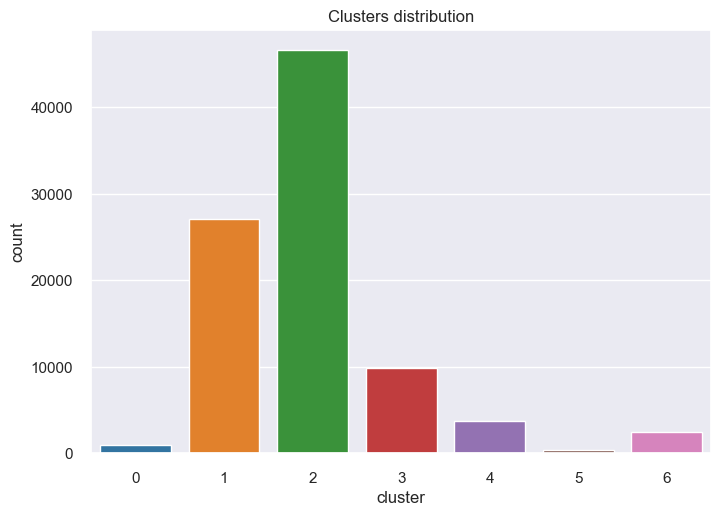

In [44]:
sns.countplot(data=cust_df, x='cluster')
plt.title("Clusters distribution")
plt.show()

Now I group the dataframe by clusters and compute the mean of each variable.

In [45]:
clust_df = cust_df.groupby('cluster').mean(numeric_only=True)

display(clust_df.head(5))

orders_number  orders_days_since_last  orders_estimated_days_mean  \
cluster                                                                      
0             1.027368              205.418947                   21.898421   
1             1.000148              234.952880                   24.049841   
2             1.002405              233.292828                   21.192549   
3             1.006265              242.465036                   31.590390   
4             1.010307              288.672833                   23.656448   

         payments_istlm_mean  payments_value_mean  payments_value_std  \
cluster                                                                 
0                   2.296140             1.896535            0.814095   
1                   4.477504             2.375949            0.000048   
2                   1.868918             1.812326            0.004592   
3                   3.295805             2.144915            0.051635   
4                   3.178720             2.132216            0.195611   

         payments_value_sum  payments_by_credit  payments_by_voucher  \
cluster                                                                
0                  1.904510           82.773768             1.512758   
1                  2.375994          247.471628             4.716859   
2                  1.813050           50.694944             2.529542   
3                  2.146801          148.076967             4.587435   
4                  2.135319          140.836213             3.900365   

         payments_by_boleto  ...  products_other  products_pets  \
cluster                      ...                                  
0                 24.472400  ...        0.004211       0.000000   
1                 42.824002  ...        0.000296       0.022357   
2                 17.666559  ...        0.000000       0.022010   
3                 37.262311  ...        0.005760       0.015865   
4                 34.503956  ...        1.058140       0.000000   

         products_sports  review_score_mean  review_answer_mean  \
cluster                                                           
0               0.001053           4.460526            2.289123   
1               0.094833           4.060113            2.622927   
2               0.094546           4.234518            2.484829   
3               0.080942           3.976405            2.852365   
4               0.000529           4.210095            2.947278   

         customer_latitude  customer_longitude  seller_latitude_top  \
cluster                                                               
0               -21.132675          -46.358846           -22.841831   
1               -22.660110          -46.816394           -22.945168   
2               -22.870733          -46.825673           -23.009925   
3                -9.102858          -41.331116           -21.030706   
4               -21.248604          -46.391304           -23.409795   

         seller_longitude_top  seller_distance_mean  
cluster                                              
0                  -47.129881          5.664532e+05  
1                  -47.426918          4.916489e+05  
2                  -47.323576          3.956608e+05  
3                  -46.201880          1.888148e+06  
4                  -47.164949          6.236980e+05  

[5 rows x 37 columns]

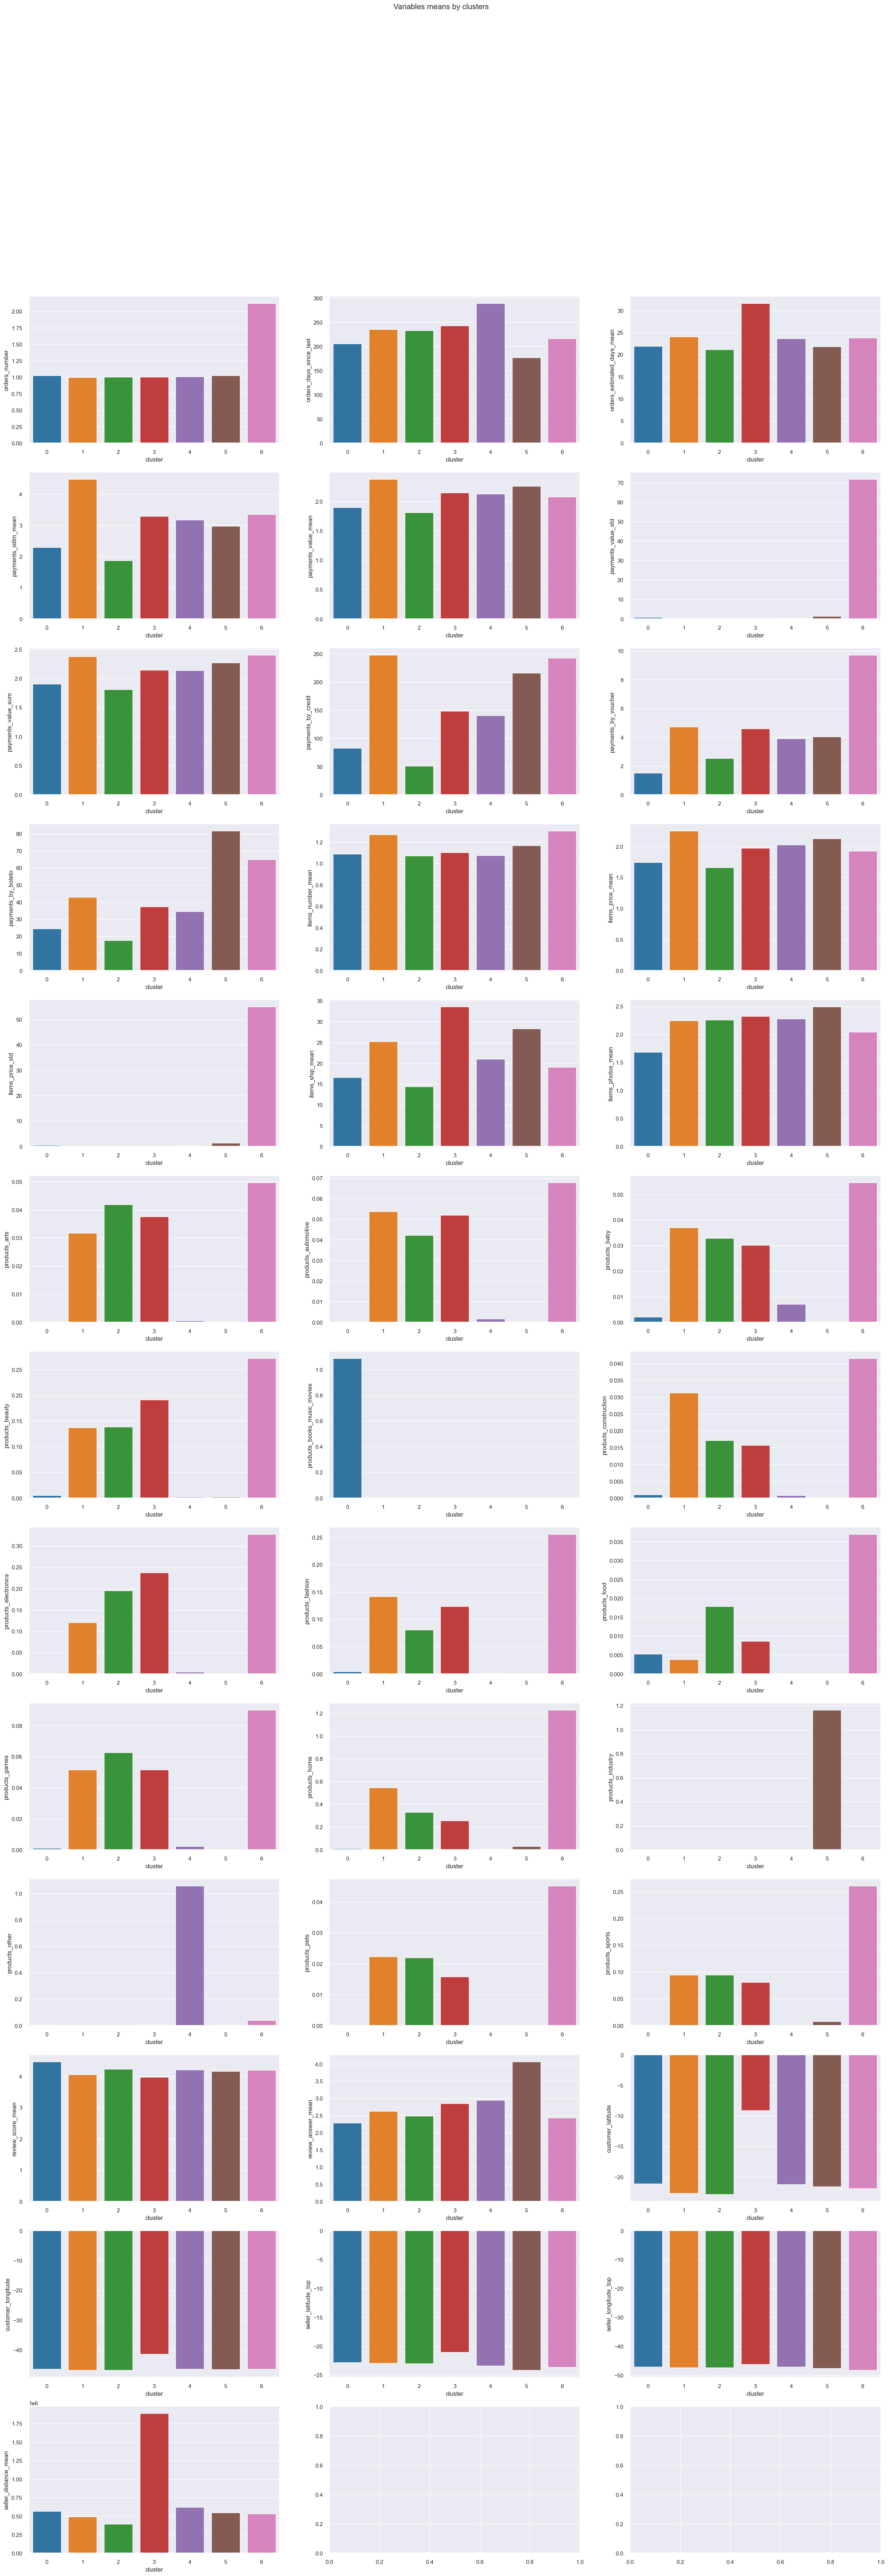

In [46]:
# Display means of variable by clusters
display_multi_barplot(clust_df, x=clust_df.index, title='Variables means by clusters', figsize=(30, 80))